In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
import torch.nn as nn

# Набор данных

In [2]:
train_dir = 'dataset/train'
valid_dir = 'dataset/validation'
test_dir = 'dataset/test'
train_csv = 'dataset/train.csv'
valid_csv = 'dataset/validation.csv'
test_csv = 'dataset/test.csv'

Расшифровка классов

In [3]:
num_to_name = {
    0: "BAS",
    1: "EBO",
    2: "EOS",
    3: "LYT",
    4: "MON",
    5: "MYO",
    6: "NGB",
    7: "NGS",
    8: "PMO",
}

#### Интерфейс для взаимодействия с набором данных

In [4]:
class LeukocytesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

#### Аугментации для выборок

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(),      # Случайное горизонтальное отражение
    # transforms.RandomVerticalFlip(),        # Случайное вертикальное отражение
    transforms.ToTensor(),                  # Преобразование в тензор
    transforms.Normalize((0.5,), (0.5,))    # Нормализация к диапазону [-1, 1]
])

In [6]:
# Трансформации для тестового и валидационного наборов данных
test_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### Создание загрузчиков данных

In [7]:
from creators.torch.LoaderCreator import LoaderCreator
from pathlib import Path

In [8]:
path = Path('dataset/')

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
loader = LoaderCreator.create(path, batch_size=4, test_size=0.2, valid_size=0.3, transform=transform)

In [11]:
len(loader.train.dataset), len(loader.valid.dataset), len(loader.test.dataset)

(512, 220, 183)

#### Визуализация данных

In [12]:
dataiter = iter(loader.train)
images, labels = next(dataiter)
images.shape

torch.Size([4, 3, 256, 256])

In [13]:
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# Создадим сетку изображений
def show_batch(images, labels):
    batch_size = len(images)
    grid_size = int(batch_size ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    for i, (img, label) in enumerate(zip(images, labels)):
        row = i // grid_size
        col = i % grid_size
        ax = axes[row, col]
        imshow(img, ax)
        ax.set_title(num_to_name[label.item()])
        ax.axis('off')
    
    plt.show()

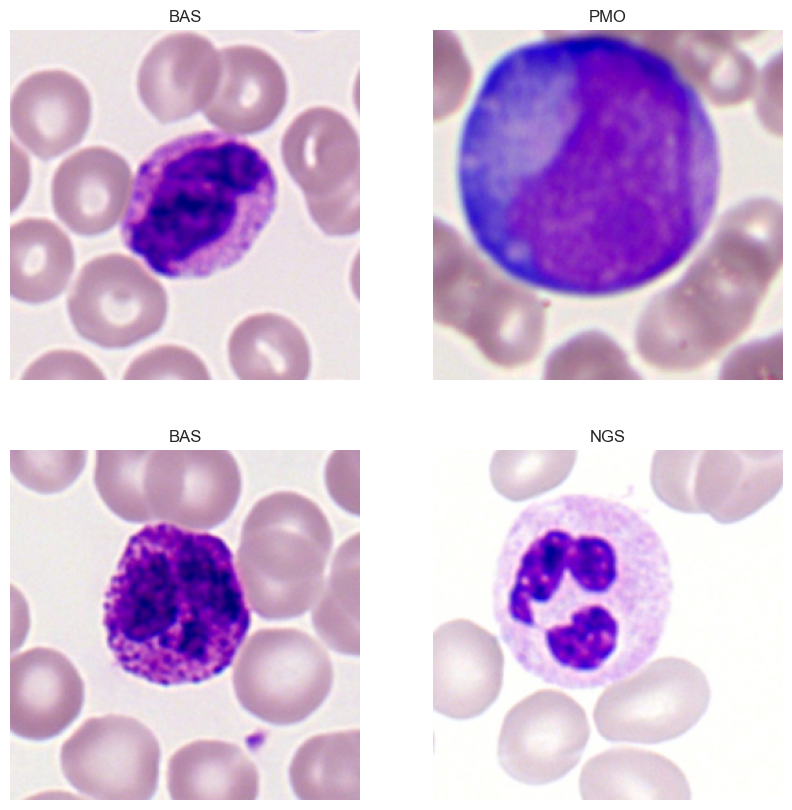

In [31]:
# Визуализируем первый батч
show_batch(images, labels)

# Обучение

### Функции, взаимодействующие с моделями

Подсчет параметров модели

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Обучение модели

In [33]:
def train(model, trainloader, valloader, criterion, optimizer, num_epochs, device='cuda'):
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        running_loss = 0.0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        
        model.eval()
        all_preds_val = []
        all_labels_val = []

        
        with torch.no_grad():
            for images, labels in valloader:
                images_val, labels_val = images.to(device), labels.to(device)

                outputs_val = model(images_val)
                _, preds_val = torch.max(outputs_val, 1)

                all_preds_val.extend(preds_val.cpu().numpy())
                all_labels_val.extend(labels_val.cpu().numpy())

        accuracy_val = accuracy_score(all_labels_val, all_preds_val)
        val_loss = criterion(outputs_val, labels_val).item()

        # Сохранение метрик
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(accuracy_val)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Validation Accuracy: {accuracy_val * 100:.2f}%")
    
    return train_losses, val_losses, val_accuracies

Тестирование модели

In [34]:
def test_model(model, test_loader, device='cuda'):
    # Оценка модели на тестовом наборе
    model.eval()
    all_preds_test = []
    all_labels_test = []

    with torch.no_grad():
        for images_test, labels_test in test_loader:
            images_test, labels_test = images_test.to(device), labels_test.to(device)

            outputs_test = model(images_test)
            _, preds_test = torch.max(outputs_test, 1)

            all_preds_test.extend(preds_test.cpu().numpy())
            all_labels_test.extend(labels_test.cpu().numpy())

        accuracy_test = accuracy_score(all_labels_test, all_preds_test)
        print(f"Final Test Accuracy: {accuracy_test * 100:.2f}%")
    
    return round(accuracy_test, 2), all_labels_test, all_preds_test

In [35]:
def visualization_metrics(train_losses, val_losses, val_accuracies, all_labels_test, all_preds_test):
    # Визуализация результатов
    plt.figure(figsize=(12, 4))

    # Кривые обучения
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Метрика точности на валидации
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    class_names = ["базофилы", "эозинофилы", "эритробласты", "лимфоциты", "моноциты", "миелобласты", "нейтрофилы_бласт", "нейтрофилы_сегмент", "промиелоциты"]
    conf_matrix = confusion_matrix(all_labels_test, all_preds_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

#### Инициализация гиперпараметров (общих для всех моделей)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [37]:
num_classes = 9
num_epochs = 40
lr = 0.001
criterion = nn.CrossEntropyLoss().to(device)

In [38]:
import torchvision.models as models

#### FineTune VGG19

In [86]:
model = models.vgg19(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)
model.to(device)
print(f'Количество параметров сети: {count_parameters(model)}')

C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Количество параметров сети: 139607113


In [81]:
start = time.time()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'Затрачено времени на обучение: {(time.time() - start) / 60} минут')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 2.508347751572728, Validation Accuracy: 10.45%
Epoch 2/40, Loss: 2.2304076086729765, Validation Accuracy: 8.18%
Epoch 3/40, Loss: 2.2149910060688853, Validation Accuracy: 8.18%
Epoch 4/40, Loss: 2.2117284601554275, Validation Accuracy: 8.18%
Epoch 5/40, Loss: 2.201833227649331, Validation Accuracy: 10.91%
Epoch 6/40, Loss: 2.207617041654885, Validation Accuracy: 8.18%
Epoch 7/40, Loss: 2.198090841062367, Validation Accuracy: 13.18%
Epoch 8/40, Loss: 2.2017771741375327, Validation Accuracy: 8.18%
Epoch 9/40, Loss: 2.206108186393976, Validation Accuracy: 10.91%
Epoch 10/40, Loss: 2.202662098221481, Validation Accuracy: 8.18%
Epoch 11/40, Loss: 2.197805975563824, Validation Accuracy: 8.18%
Epoch 12/40, Loss: 2.1981091052293777, Validation Accuracy: 10.91%
Epoch 13/40, Loss: 2.2004746263846755, Validation Accuracy: 8.18%
Epoch 14/40, Loss: 2.193624336272478, Validation Accuracy: 10.91%
Epoch 15/40, Loss: 2.1968703093007207, Validation Accuracy: 8.18%
Epoch 16/40, Loss: 2.

KeyboardInterrupt: 

FineTune MobileNetV2

In [39]:
from torchvision.models import mobilenet_v2

In [40]:
model = mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model.to(device)
print(f'Количество параметров сети: {count_parameters(model)}')

Количество параметров сети: 2235401


C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
start = time.time()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = train(model, loader.train, loader.valid, criterion, optimizer, num_epochs)
print(f'Затрачено времени на обучение: {(time.time() - start) / 60} минут')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 0.23062294764577018, Validation Accuracy: 70.00%
Epoch 2/40, Loss: 0.24356300168437883, Validation Accuracy: 74.09%
Epoch 3/40, Loss: 0.18252401924405603, Validation Accuracy: 67.73%
Epoch 4/40, Loss: 0.15063144373016257, Validation Accuracy: 74.55%
Epoch 5/40, Loss: 0.18358483888073351, Validation Accuracy: 64.09%
Epoch 6/40, Loss: 0.1702289445174756, Validation Accuracy: 68.18%
Epoch 7/40, Loss: 0.1301655793286045, Validation Accuracy: 71.82%
Epoch 8/40, Loss: 0.24631813325822804, Validation Accuracy: 67.73%
Epoch 9/40, Loss: 0.11579147343400109, Validation Accuracy: 72.27%
Epoch 10/40, Loss: 0.17919378931082974, Validation Accuracy: 76.82%
Epoch 11/40, Loss: 0.1287145026926737, Validation Accuracy: 68.18%
Epoch 12/40, Loss: 0.12393984663322044, Validation Accuracy: 72.73%
Epoch 13/40, Loss: 0.08591358079888778, Validation Accuracy: 76.36%
Epoch 14/40, Loss: 0.17566114271880906, Validation Accuracy: 65.45%
Epoch 15/40, Loss: 0.3085049384717422, Validation Accuracy: 

In [60]:
acc, all_labels, all_preds = test_model(model, loader.test)

Final Test Accuracy: 73.77%


In [61]:
import datetime
torch.save(model.state_dict(), f'weights/mobilenetv2-{acc}-{datetime.date.today().strftime("%Y-%m-%d")}.pth')

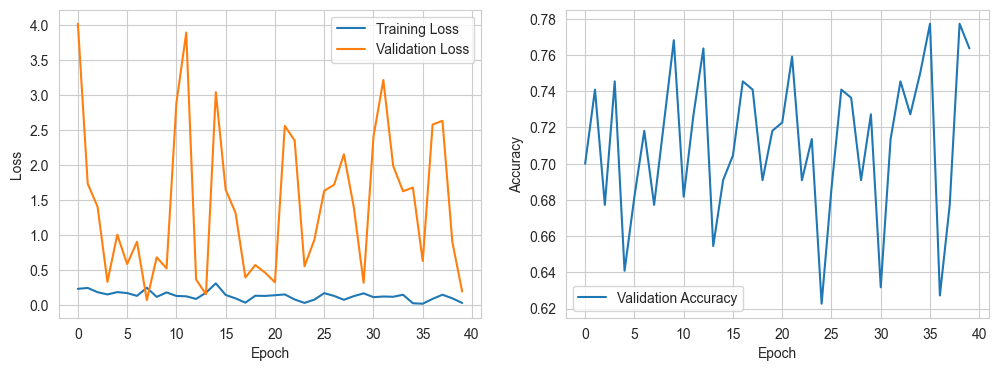

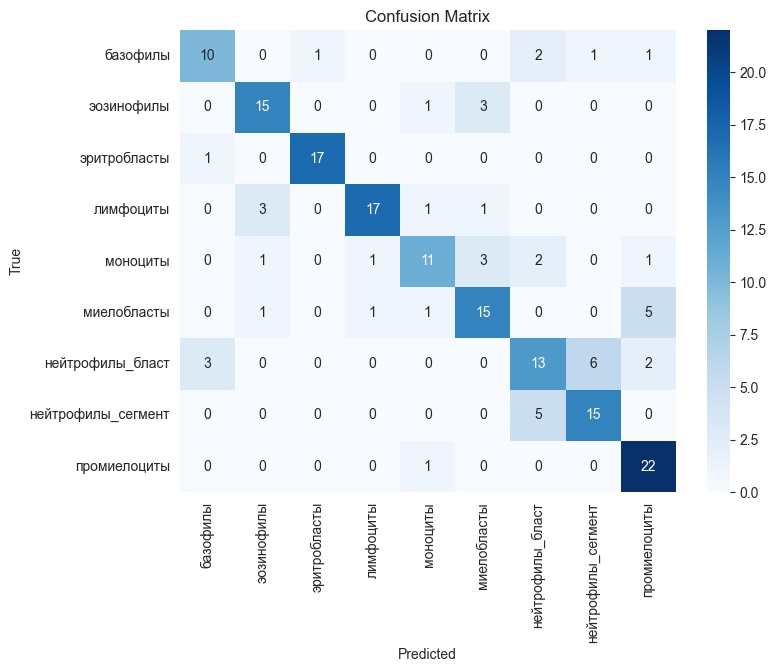

In [62]:
visualization_metrics(train_losses, val_losses, val_accuracies, all_labels, all_preds)

Resnet FineTune

In [101]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)
model_resnet18.to(device)
print(f'Количество параметров сети: {count_parameters(model_resnet18)}')

Количество параметров сети: 11181129


In [102]:
start = time.time()
optimizer = optim.Adam(model_resnet18.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = train(model_resnet18, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'Затрачено времени на обучение: {(time.time() - start) / 60} минут')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 2.016786063555628, Validation Accuracy: 26.82%
Epoch 2/40, Loss: 1.7835410912521183, Validation Accuracy: 56.36%
Epoch 3/40, Loss: 1.5209276562090963, Validation Accuracy: 25.91%
Epoch 4/40, Loss: 1.476594741921872, Validation Accuracy: 42.27%
Epoch 5/40, Loss: 1.4060441884212196, Validation Accuracy: 45.45%
Epoch 6/40, Loss: 1.3431393831269816, Validation Accuracy: 56.82%
Epoch 7/40, Loss: 1.278266520705074, Validation Accuracy: 62.73%
Epoch 8/40, Loss: 1.2286783286253922, Validation Accuracy: 64.09%
Epoch 9/40, Loss: 1.1610110593028367, Validation Accuracy: 42.27%
Epoch 10/40, Loss: 1.2356828062329441, Validation Accuracy: 65.45%
Epoch 11/40, Loss: 1.1446904118638486, Validation Accuracy: 57.73%
Epoch 12/40, Loss: 1.0784475120017305, Validation Accuracy: 70.00%
Epoch 13/40, Loss: 1.1086637240368873, Validation Accuracy: 68.18%
Epoch 14/40, Loss: 1.0475535332225263, Validation Accuracy: 74.55%
Epoch 15/40, Loss: 0.974981876090169, Validation Accuracy: 75.45%
Epoch 16

In [103]:
acc, all_labels, all_preds = test_model(model_resnet18, test_loader)

Final Test Accuracy: 77.05%


In [104]:
torch.save(model.state_dict(), f'weights/resnet18-{acc}-{datetime.date.today().strftime("%Y-%m-%d")}.pth')

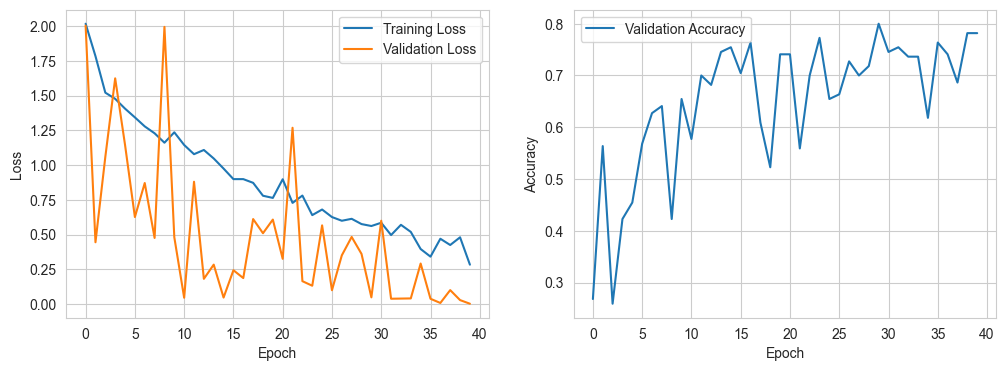

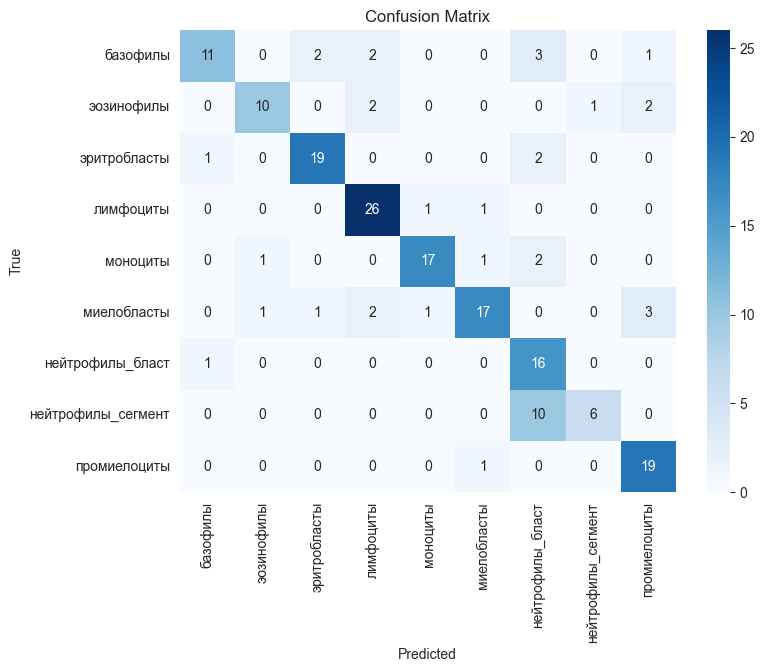

In [105]:
visualization_metrics(train_losses, val_losses, val_accuracies, all_labels, all_preds)

SqueezeNet FineTune

In [114]:
model_squeezenet = models.squeezenet1_0(pretrained=True)
model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_squeezenet.num_classes = num_classes
model_squeezenet.to(device)
print(f'Количество параметров сети: {count_parameters(model_squeezenet)}')

Количество параметров сети: 740041


C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
start = time.time()
optimizer = optim.Adam(model_squeezenet.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = train(model_squeezenet, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'Затрачено времени на обучение: {(time.time() - start) / 60} минут')

  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/40, Loss: 2.214124242775142, Validation Accuracy: 7.27%
Epoch 2/40, Loss: 2.197901614010334, Validation Accuracy: 7.73%
Epoch 3/40, Loss: 2.2049221638590097, Validation Accuracy: 10.91%
Epoch 4/40, Loss: 2.197507616132498, Validation Accuracy: 8.18%
Epoch 5/40, Loss: 2.1948856879025698, Validation Accuracy: 8.18%
Epoch 6/40, Loss: 2.193156667985022, Validation Accuracy: 8.18%
Epoch 7/40, Loss: 2.19342933408916, Validation Accuracy: 7.73%
Epoch 8/40, Loss: 2.1934042423963547, Validation Accuracy: 3.18%
Epoch 9/40, Loss: 2.1913792323321104, Validation Accuracy: 7.73%
Epoch 10/40, Loss: 2.1928018582984805, Validation Accuracy: 8.18%
Epoch 11/40, Loss: 2.1892925230786204, Validation Accuracy: 8.18%
Epoch 12/40, Loss: 2.1880240105092525, Validation Accuracy: 8.18%
Epoch 13/40, Loss: 2.1860244320705533, Validation Accuracy: 8.18%
Epoch 14/40, Loss: 2.186511505395174, Validation Accuracy: 8.18%
Epoch 15/40, Loss: 2.194994071498513, Validation Accuracy: 8.18%
Epoch 16/40, Loss: 2.18713

In [111]:
acc, all_labels, all_preds = test_model(model_squeezenet, test_loader)

Final Test Accuracy: 10.38%


C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


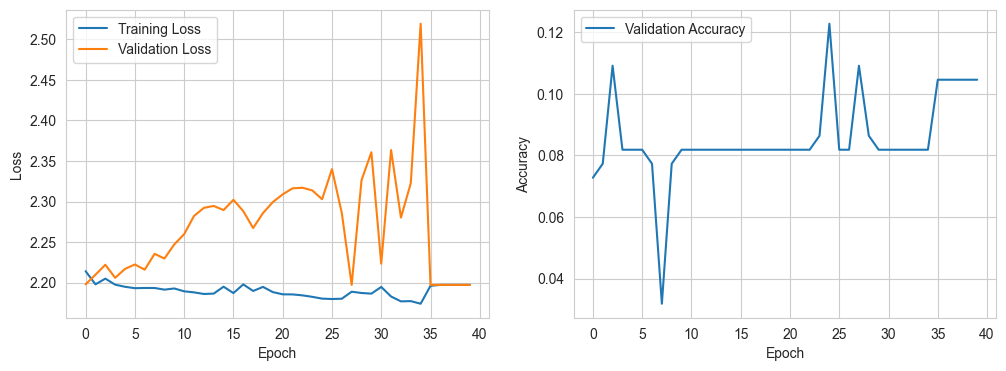

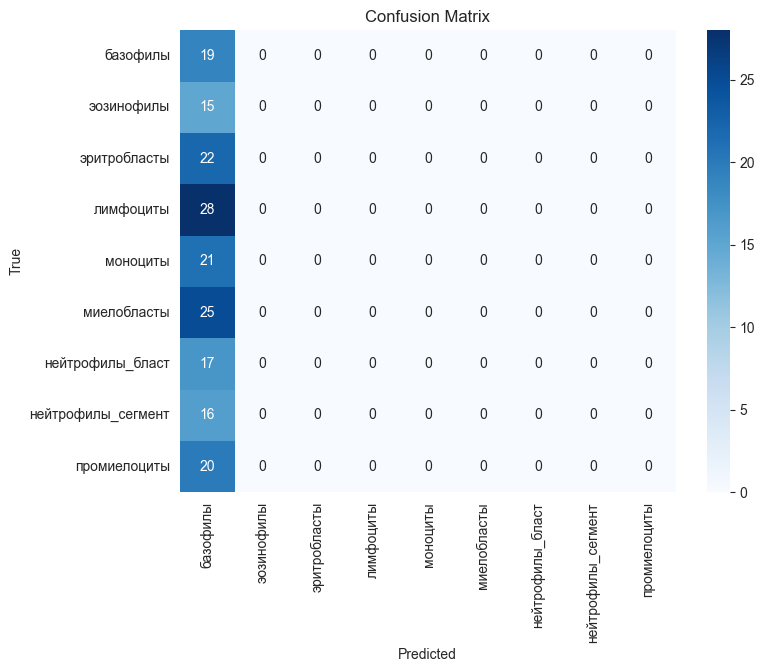

In [112]:
visualization_metrics(train_losses, val_losses, val_accuracies, all_labels, all_preds)

Вывод: большие модели (VGG, AlexNet, SqueezeNet) являются непригодными для текущей задачи. Когда количество обучающих данных ограничено, использование очень сложных моделей с большим количеством параметров может привести к затуханию градиента и низкой производительности на валидационной выборке.

FineTune EfficientNet

In [116]:
model_efficientnet = models.efficientnet_b0(pretrained=True)
num_ftrs = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs, num_classes)
model_efficientnet.to(device)
print(f'Количество параметров сети: {count_parameters(model_efficientnet)}')

C:\Users\mrtsstlrs\PycharmProjects\researchwork\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\mrtsstlrs/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:16<00:00, 1.27MB/s]

Количество параметров сети: 4019077


In [117]:
start = time.time()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = train(model_efficientnet, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'Затрачено времени на обучение: {(time.time() - start) / 60} минут')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 1.7400254467502236, Validation Accuracy: 35.91%
Epoch 2/40, Loss: 1.4786094892770052, Validation Accuracy: 62.73%
Epoch 3/40, Loss: 1.0959600824862719, Validation Accuracy: 66.82%
Epoch 4/40, Loss: 1.0335685580503196, Validation Accuracy: 72.27%
Epoch 5/40, Loss: 0.8951292853453197, Validation Accuracy: 66.82%
Epoch 6/40, Loss: 0.7661526504671201, Validation Accuracy: 75.00%
Epoch 7/40, Loss: 0.7627988274907693, Validation Accuracy: 80.00%
Epoch 8/40, Loss: 0.700108758173883, Validation Accuracy: 76.82%
Epoch 9/40, Loss: 0.572766302855598, Validation Accuracy: 85.91%
Epoch 10/40, Loss: 0.5401992728875484, Validation Accuracy: 82.73%
Epoch 11/40, Loss: 0.5076825799405924, Validation Accuracy: 82.73%
Epoch 12/40, Loss: 0.6262567562662298, Validation Accuracy: 83.64%
Epoch 13/40, Loss: 0.37448977452731924, Validation Accuracy: 78.64%
Epoch 14/40, Loss: 0.4652203368168557, Validation Accuracy: 80.45%
Epoch 15/40, Loss: 0.3178299006613088, Validation Accuracy: 85.45%
Epoch

In [119]:
acc, all_labels, all_preds = test_model(model_efficientnet, test_loader)

Final Test Accuracy: 78.69%


In [120]:
torch.save(model.state_dict(), f'weights/efficientnet_b0-{acc}-{datetime.date.today().strftime("%Y-%m-%d")}.pth')

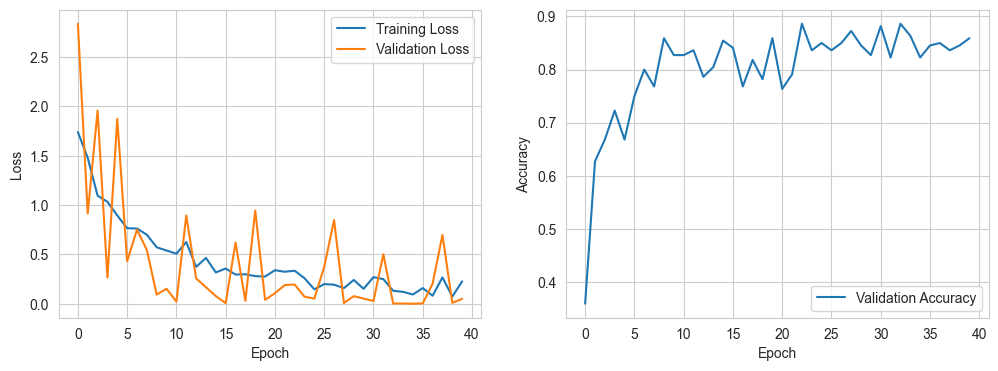

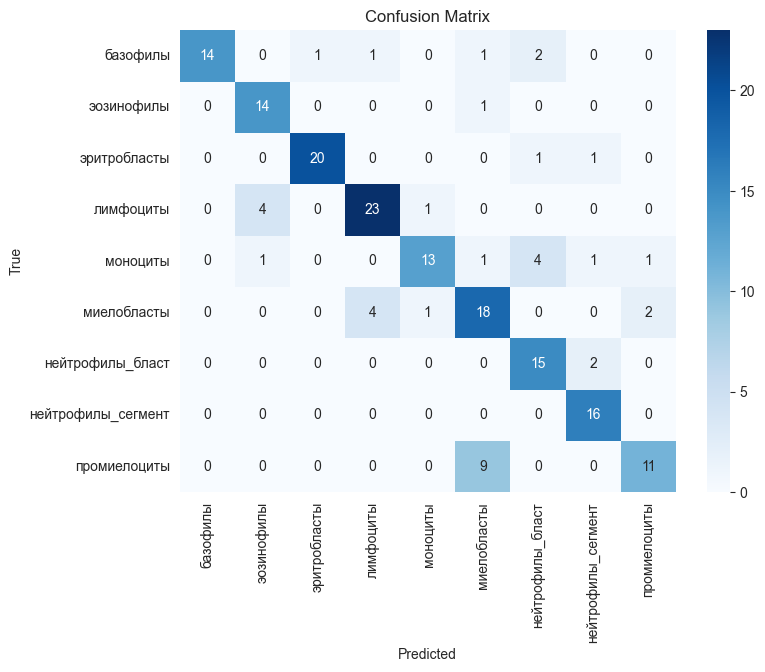

In [121]:
visualization_metrics(train_losses, val_losses, val_accuracies, all_labels, all_preds)